# 🟢 Differences between DPI and MDI Inhaler Prescribing in England: Step-by-step Analysis (2023)

This notebook has been developed to support the Heidelberg Institute's initiative to analyse climate-sensitive inhaler prescribing patterns in selected European countries in 2023. It specifically focuses on prescriptions clustered by Anatomical Therapeutic Chemical (ATC) codes, categorised into:

-   Short-acting beta-agonists (**SABA**)
-   Long-acting beta-agonists (**LABA**)
-   **Anticholinergic Drugs**
-   Inhaled corticosteroids (**ICS**)
-   Adrenergics in combination with corticosteroids or other drugs, excl. anticholinergics (**Combi_1**)
-   Adrenergics in combination with anticholinergics incl. triple combinations with corticosteroids ((**Combi_2**)

Additionally, the inhalers are differentiated by device type:

-   **Pressurised Metered Dose Inhalers (pMDI)**: Known for higher carbon footprints.
-   **Dry Powder Inhalers (DPI)**: Lower environmental impact compared to pMDIs.

A third category is also available:
-   **Soft Mist Inhalers (SMI)**: These have a lower carbon footprint compared to pMDIs, but differ from DPIs and are therefore analysed separately.

#### **What the steps are:**

1.  Find all inhaler devices that are DPI, MDI or SMI.
2.  Link these to BNF codes and restrict to only *respiratory* medicines.
3.  Add ATC codes to these inhalers.
4.  Pull all 2023 prescribing for relevant BNF codes.
5.  **Merge** these datasets to produce the final summary---using a "fuzzy" BNF code match to ensure both brands and generics are counted.
6.  Save and check each result at every stage.


Below is a subsection of the Entity Relationship Diagram (ERD) illustrating how the key tables link together:

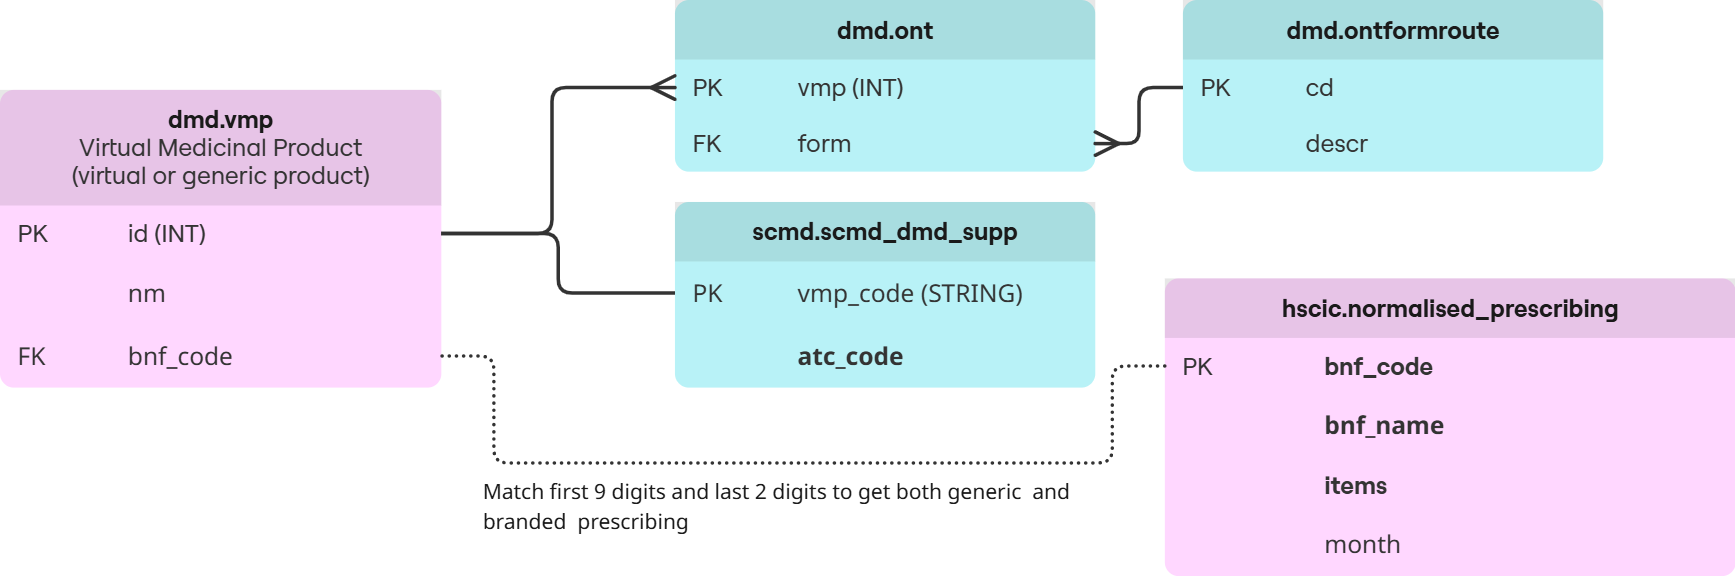

### Imports & BigQuery client setup

In [2]:
# Imports & BigQuery client setup
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import os


# Authenticate using a local service account JSON file
credentials = service_account.Credentials.from_service_account_file(
    '../credentials.json'
)
client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

### Explore ontology form and route descriptions to identify inhalers.

The dmd dataset has a table 'ontformroute' with Ontology Form & Route associated with each VMP. To begin with, we search for all products with "inhalation" in the description, to identify which descriptions specifically match to inhalers.

In [3]:
# SQL: Find all formroute descriptions containing 'inhalation'
sql_inhalation_forms = """
  SELECT
   descr,
  FROM `dmd.ontformroute` AS r
  WHERE LOWER(r.descr) LIKE '%inhalation%';
"""
df_inhalation = client.query(sql_inhalation_forms).to_dataframe()

**This query will process 9.69 KB when run.**

In [45]:
print(df_inhalation)

                                   descr
0       pressurizedinhalation.inhalation
1            powderinhalation.inhalation
2           solutionnebuliser.inhalation
3        suspensioninhalation.inhalation
4         suspensionnebuliser.inhalation
5            vapourinhalation.inhalation
6               gasinhalation.inhalation
7                 liquiddrops.inhalation
8                 vapourinhalation.nasal
9        impregnatedcigarette.inhalation
10         inhalationsolution.inhalation
11        dispersionnebuliser.inhalation
12     vapourinhalationliquid.inhalation
13        vapourinhalationointment.nasal
14  vapourinhalationimpregnatedpad.nasal
15         vapourinhalationcapsule.nasal
16        vapourinhalationemulsion.nasal
17          vapourinhalationliquid.nasal
18        vapourinhalationsolution.nasal


*This has identified 3 descriptions for inhaler devices:
pressurizedinhalation.inhalation, powderinhalation.inhalation and inhalationsolution.inhalation*

### **Step 1**: Get Inhaler Devices 

We identify all medicines in the NHS dictionary of medicines and devices (`dm+d`) that are either:
-   Dry powder inhalers (DPI)
-   Metered dose inhalers (MDI)
-   Soft Mist Inhalers (SMIs)


In [4]:
sql_inhaler_forms = """
SELECT
  o.vmp AS vmp_code,
  r.descr AS form_descr
FROM `dmd.ont` AS o
LEFT JOIN `dmd.ontformroute` AS r
  ON o.form = r.cd
WHERE r.descr IN (
  'powderinhalation.inhalation',    -- DPI
  'pressurizedinhalation.inhalation',-- MDI
  'inhalationsolution.inhalation'-- SMI  
)
"""
inhaler_forms = client.query(sql_inhaler_forms).to_dataframe()

**This query will process  354.13 KB when run.**

In [5]:
display(inhaler_forms.head(10))
inhaler_forms.to_csv('../data/interim-file_inhaler_forms.csv', index=False)

,vmp_code,form_descr
0,39113611000001102,pressurizedinhalation.inhalation
1,36049211000001106,pressurizedinhalation.inhalation
2,36049311000001103,pressurizedinhalation.inhalation
3,39110811000001105,pressurizedinhalation.inhalation
4,35926711000001101,pressurizedinhalation.inhalation
5,35926611000001105,pressurizedinhalation.inhalation
6,36049411000001105,pressurizedinhalation.inhalation
7,39110911000001100,pressurizedinhalation.inhalation
8,39111011000001108,pressurizedinhalation.inhalation
9,39111111000001109,pressurizedinhalation.inhalation


### **Step 2**: Link Inhalers to BNF Codes, Restrict to Respiratory

We link the inhalers found in Step 1 to their BNF codes, but only keeps those medicines for **respiratory diseases** (BNF codes starting with `'03'`).

In [6]:
sql_bnf = """
SELECT
  id AS vmp_code,
  bnf_code
FROM `dmd.vmp`
WHERE bnf_code LIKE '03%'   -- Only respiratory medicines
"""
vmp_bnf = client.query(sql_bnf).to_dataframe()

**This query will process 454.48 KB when run.**

In [7]:
# Merge with Step 1 in Python (inner join used here as left join will include inhalers that aren't for respiratory conditions)
respiratory_inhalers = inhaler_forms.merge(vmp_bnf, how='inner', on='vmp_code')
display(respiratory_inhalers.head(10))
respiratory_inhalers.to_csv('../data/interim-file_respiratory_inhalers.csv', index=False)


,vmp_code,form_descr,bnf_code
0,39113611000001102,pressurizedinhalation.inhalation,0301011R0AAAPAP
1,36049211000001106,pressurizedinhalation.inhalation,0301020I0AAAGAG
2,36049311000001103,pressurizedinhalation.inhalation,0301020I0AAAAAA
3,39110811000001105,pressurizedinhalation.inhalation,0301011U0AAACAC
4,35926711000001101,pressurizedinhalation.inhalation,0303010Q0AAABAB
5,35926611000001105,pressurizedinhalation.inhalation,0303010Q0AAAHAH
6,36049411000001105,pressurizedinhalation.inhalation,0301020I0AAADAD
7,39110911000001100,pressurizedinhalation.inhalation,0302000N0AABHBH
8,39111011000001108,pressurizedinhalation.inhalation,0302000N0AABEBE
9,39111111000001109,pressurizedinhalation.inhalation,0302000N0AABFBF


### **Step 3**: Add ATC Codes
The NHS Business Services Authority (NHSBSA) utilises [British National Formulary (BNF) codes](https://www.bennett.ox.ac.uk/blog/2017/04/prescribing-data-bnf-codes/) to report medicines that have been prescribed and dispensed. For this task, we need to compare prescribing data clustered by [Anatomical Therapeutic Chemical (ATC) codes](https://atcddd.fhi.no/atc/structure_and_principles/), which are maintained by the World Health Organisation (WHO).

To achieve this, we will:
-   Use the scmd.scmd_dmd_supp table, which contains information linking **Virtual Medicinal Product (VMP)** codes to their corresponding ATC codes.
-   Integrate this data with our existing respiratory_inhalers dataframe, matching each inhaler's VMP code with its associated ATC classification.

In [8]:
sql_atc = """
SELECT
  vmp_code,
  atc_code
FROM `scmd.scmd_dmd_supp`
"""
atc_codes = client.query(sql_atc).to_dataframe()


**This query will process 539.75 KB when run.**

In [9]:
# Make sure both columns are strings before merging (vmp_code is stored as string in scmd.scmd_dmd_supp and integer in the other tables)
respiratory_inhalers['vmp_code'] = respiratory_inhalers['vmp_code'].astype(str)
atc_codes['vmp_code'] = atc_codes['vmp_code'].astype(str)

# Merge with Step 2 in Python (LEFT join used here to idenfify if there are any inhalers without an ATC code)
vmp_atc_form = respiratory_inhalers.merge(atc_codes, how='left', on='vmp_code')
display(vmp_atc_form.head(10))
vmp_atc_form.to_csv('../data/interim-file_vmp_atc_form.csv', index=False)

,vmp_code,form_descr,bnf_code,atc_code
0,39113611000001102,pressurizedinhalation.inhalation,0301011R0AAAPAP,R03AC02
1,36049211000001106,pressurizedinhalation.inhalation,0301020I0AAAGAG,R03BB01
2,36049311000001103,pressurizedinhalation.inhalation,0301020I0AAAAAA,R03BB01
3,39110811000001105,pressurizedinhalation.inhalation,0301011U0AAACAC,R03AC12
4,35926711000001101,pressurizedinhalation.inhalation,0303010Q0AAABAB,R03BC01
5,35926611000001105,pressurizedinhalation.inhalation,0303010Q0AAAHAH,R03BC01
6,36049411000001105,pressurizedinhalation.inhalation,0301020I0AAADAD,R03BB01
7,39110911000001100,pressurizedinhalation.inhalation,0302000N0AABHBH,R03BA05
8,39111011000001108,pressurizedinhalation.inhalation,0302000N0AABEBE,R03AK06
9,39111111000001109,pressurizedinhalation.inhalation,0302000N0AABFBF,R03AK06


### **Step 4**: Pull 2023 Prescribing for Respiratory Codes

We pull all NHS prescribing records from 2023 for medicines with a respiratory BNF code (starts with `'03'`).\
We only get  the BNF codes, BNF names and the total items prescribed.

In [10]:
sql_prescribing = """
SELECT
  bnf_code,
  bnf_name,
  SUM(items) AS total_items
FROM `hscic.normalised_prescribing`
WHERE EXTRACT(YEAR FROM month) = 2023
  AND bnf_code LIKE '03%'
GROUP BY
  bnf_code,
  bnf_name
ORDER BY
  total_items DESC
"""
resp_prescribing_2023 = client.query(sql_prescribing).to_dataframe()

**This query will process 174.9 GB when run.**

In [11]:
display(resp_prescribing_2023.head(10))
resp_prescribing_2023.to_csv('../data/interim-file_resp_prescribing_2023.csv', index=False)

,bnf_code,bnf_name,total_items
0,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (T...,7373702
1,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,7315130
2,0303020G0AAABAB,Montelukast 10mg tablets,3932801
3,0302000C0BQAABX,Fostair 100micrograms/dose / 6micrograms/dose ...,3813446
4,0304010E0AAABAB,Fexofenadine 180mg tablets,3491257
5,0301011R0BEAIAP,Ventolin 100micrograms/dose Evohaler,3462642
6,0304010I0AAAAAA,Cetirizine 10mg tablets,3238191
7,0307000J0AAAAAA,Carbocisteine 375mg capsules,3138166
8,0302000C0BPABBF,Clenil Modulite 100micrograms/dose inhaler,2656756
9,0302000AABBAAAA,Trimbow 87microg/dose / 5microg/dose / 9microg...,2109057


### **Step 5**: Merge and Do the Fuzzy BNF Code Join in Python

We now match ourATC  mapped list of inhalers (vmp_atc_form) to the respiratory prescribing data for 2023.\
Because BNF codes are [slightly different for brands and generics](https://www.bennett.ox.ac.uk/blog/2017/04/prescribing-data-bnf-codes/#:~:text=The%20images%20below,and%20strength%20%26%20formulation.), we "fuzzily" match by:

-   Taking the first 9 and last 2 characters of each code
-   Joining on that, rather than exact match

This ensures we *capture* both generic and brand prescribing.

In [12]:
# Prepare codes for "fuzzy" join
# vmp_atc_form holds  mapping of each VMP to its ATC code and formulation description (form_descr).
#resp_prescribing_2023 contains the aggregated prescribing data for 2023, keyed by a BNF code and total items dispensed.

vmp_atc_form['bnf_merge'] = vmp_atc_form['bnf_code'].str[:9] + vmp_atc_form['bnf_code'].str[-2:]
resp_prescribing_2023['bnf_merge'] = resp_prescribing_2023['bnf_code'].str[:9] + resp_prescribing_2023['bnf_code'].str[-2:]

# Merge using inner join (only interested in hnhalers that were prescribed in 2023)
# The suffixes argument prevents column‐name clashes by appending _presc to any columns from the prescribing table that duplicate those in vmp_atc_form.

final = vmp_atc_form.merge(
    resp_prescribing_2023,
    how='inner',             # not 'centre'
    on='bnf_merge',        
    suffixes=('', '_presc')
)

# Assign a human-readable device type label
#form_descr is the raw DMD ontology description (e.g. "powderinhalation.inhalation").
#map_device() converts these to human-readable device classes:

def map_device(form_descr):
    if form_descr == 'powderinhalation.inhalation':
        return 'DPI'
    elif form_descr == 'pressurizedinhalation.inhalation':
        return 'MDI'
    elif form_descr == 'inhalationsolution.inhalation':
        return 'SMI'     
    else:
        return 'Other'

final['form'] = final['form_descr'].apply(map_device)

# Group by device class, BNF code, name, and inhaler type; sum items prescribed
final_grouped = (
    final.groupby(['atc_code', 'bnf_code_presc', 'bnf_name', 'form'], dropna=False)['total_items']
    .sum()
    .reset_index(name='total_items')
    .sort_values('total_items', ascending=False)
)

display(final_grouped.head(10))
final_grouped.to_csv('../data/interim-file_atc_bnf_inhalerforms_withitems.csv', index=False)


,atc_code,bnf_code_presc,bnf_name,form,total_items
10,R03AC02,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (T...,MDI,7373702
2,R03AC02,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,MDI,7315130
110,R03AK08,0302000C0BQAABX,Fostair 100micrograms/dose / 6micrograms/dose ...,MDI,3813446
9,R03AC02,0301011R0BEAIAP,Ventolin 100micrograms/dose Evohaler,MDI,3462642
178,R03BA01,0302000C0BPABBF,Clenil Modulite 100micrograms/dose inhaler,MDI,2656756
150,R03AL09,0302000AABBAAAA,Trimbow 87microg/dose / 5microg/dose / 9microg...,MDI,2109057
148,R03AL08,0302000Z0BBAAAA,Trelegy Ellipta 92microg/55microg/22microg/dos...,DPI,1407956
111,R03AK08,0302000C0BQABBZ,Fostair 200micrograms/dose / 6micrograms/dose ...,MDI,1339036
112,R03AK08,0302000C0BRAABY,Fostair NEXThaler 100microg/dose / 6microg/dos...,DPI,1256597
93,R03AK07,0302000K0BDABAM,Symbicort 200/6 Turbohaler,DPI,1184400


### **Step 6**: Cluster Inhalers by ATC Category

We group products into clinically meaningful groups:
- **SABA:** R03AC0 
- **LABA:** R03AC1
- **Anticholinergic:** R03BB
- **ICS:** R03BA
- **Combi_1:** R03AK (Adrenergics in combination with corticosteroids or other drugs, excl. anticholinergics)
- **Combi_2:** R03AL (Adrenergics in combination with anticholinergics incl. triple combinations with corticosteroids)
- **Other:** everything else not captured in the requested categories (for data quality checking)

We then calculate the percentage of items delivered as DPI in each cluster.

In [13]:
# Define cluster order and prefixes
cluster_order = ['SABA','LABA','Anticholinergic','ICS','Combi_1','Combi_2','Other']
prefixes = {
    'SABA': 'R03AC0',
    'LABA': 'R03AC1',
    'Anticholinergic': 'R03BB',
    'ICS': 'R03BA',
    'Combi_1': 'R03AK',
    'Combi_2': 'R03AL'
}

# Assign each row to a cluster
final_grouped['cluster'] = 'Other'
for name, pref in prefixes.items():
    mask = final_grouped['atc_code'].str.startswith(pref, na=False)
    final_grouped.loc[mask, 'cluster'] = name

# Aggregate total_items by cluster and form
cluster_totals = (
    final_grouped.groupby(['cluster','form'])['total_items']
      .sum()
      .unstack(fill_value=0)
)

# Compute DPI percentage of total
cluster_totals['DPI_percentage'] = (
    cluster_totals.get('DPI', 0) /
    cluster_totals.sum(axis=1) * 100
).round(1)

# Reindex to desired order
d = cluster_totals.reindex(cluster_order)
disp = d[['DPI','MDI','SMI','DPI_percentage']].fillna(0)
print("DPI uptake by ATC cluster (items share):")
display(disp)

DPI uptake by ATC cluster (items share):


form,DPI,MDI,SMI,DPI_percentage
cluster,,,,
SABA,1665854,19311597,0,7.9
LABA,88319,149676,2023,36.8
Anticholinergic,1953055,149354,1219760,58.8
ICS,626063,5550191,0,10.1
Combi_1,6353609,8303681,0,43.3
Combi_2,3199687,2380495,353908,53.9
Other,15750,119,0,99.3


This table shows for each clinical category (e.g. SABA, ICS, etc.) the number of items dispensed as DPI, MDI, SMI, and the percentage delivered as DPI.

### **Step 7**: Visualise DPI Uptake by Cluster

A bar chart helps us easily compare DPI use by clinical group.

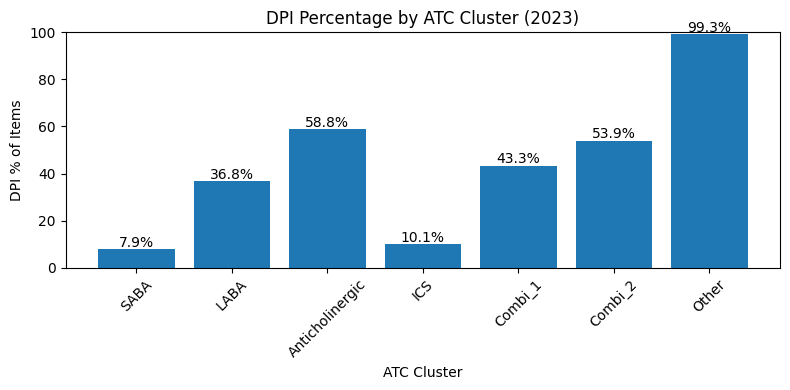

In [14]:
# Bar chart of DPI % by cluster
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(disp.index, disp['DPI_percentage'])
ax.set_title('DPI Percentage by ATC Cluster (2023)')
ax.set_ylabel('DPI % of Items')
ax.set_xlabel('ATC Cluster')
ax.set_ylim(0,100)
ax.ticklabel_format(style='plain', axis='y')
for i, val in enumerate(disp['DPI_percentage']):
    ax.text(i, val+1, f'{val:.1f}%', ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Step 8**:. Inspecting the 'Other' Cluster for Potential Misclassification

Some inhalers may end up in the "Other" cluster if the ATC code is missing or unusual. Here, we check which products these are, and how much prescribing volume they account for.


In [15]:
# Filter the DataFrame to the 'Other' cluster
other_cluster = (
    final_grouped[final_grouped['cluster'] == 'Other']
      # Select key columns for review
      .loc[:, ['atc_code', 'bnf_code_presc', 'bnf_name', 'form', 'total_items']]
)
# Calculate what percentage of overall prescribing items this cluster represents
other_total_items = other_cluster['total_items'].sum()
overall_total_items = final_grouped['total_items'].sum()
print(f"Other cluster total items: {other_total_items:,} "
      f"({other_total_items/overall_total_items*100:.3f}% of all inhaler items)")

print("All inhalers in 'Other' cluster with prescribing volumes:")
print(other_cluster.to_string(index=False))

Other cluster total items: 15,869 (0.031% of all inhaler items)
All inhalers in 'Other' cluster with prescribing volumes:
atc_code  bnf_code_presc                                                    bnf_name form  total_items
     n/a 0302000W0BBAAAA   Enerzair Breezhaler 114microg / 46microg / 136microg/dose  DPI        15683
 R03BC01 0303010Q0AAANAN               Sodium cromoglicate 5mg/dose inhaler CFC free  MDI           88
     n/a 0302000W0AAAAAA Generic Enerzair Breezhaler 114/46/136microg inh caps + dev  DPI           49
 R03BC01 0303010Q0BBALAN                             Intal 5mg/dose inhaler CFC free  MDI           29
 R05CB16 0307000R0BBAAAA Bronchitol 40mg inhalation powder capsules with two devices  DPI           16
 R05CB16 0307000R0AAAAAA   Mannitol 40mg inhalation powder capsules with two devices  DPI            2
 R03BC03 0303010J0AAADAD                        Nedocromil 2mg/dose inhaler CFC free  MDI            2


*We can now spot any products needing review. We observe seven products in this group. Six of these are not part of the defined therapeutic clusters, so their placement here is expected. However, Enerzair Breezhaler (indacaterol, glycopyrronium bromide and mometasone) appears under 'Other' due to a missing ATC code (n/a), indicating a misclassification -ATC code should be [R03AL12](https://atcddd.fhi.no/atc_ddd_index/?code=R03AL12)*
### **Step 9**: Assess and Correct Misclassified Inhalers

Enerzair Breezhaler was placed in "Other" due to a missing ATC code.
We reclassify it to "Combi_2" (ATC code R03AL12) and see how this affects our results.

In [16]:
# 1. Identify Enerzair Breezhaler products in the 'Other' cluster
enerzair_mask = (
    (final_grouped['cluster'] == 'Other') &
    (final_grouped['bnf_name'].str.contains('Enerzair Breezhaler', case=False, na=False))
)
enerzair_products = final_grouped.loc[enerzair_mask].copy()

# 2. Reassign these products to 'Combi_2' and give their ATC code (R03AL12) using pandas only
final_grouped.loc[enerzair_mask, 'atc_code'] = 'R03AL12'
final_grouped.loc[enerzair_mask, 'cluster'] = 'Combi_2'

# 3. Recalculate cluster totals as before
cluster_totals_new = (
    final_grouped.groupby(['cluster','form'])['total_items']
      .sum()
      .unstack(fill_value=0)
)
cluster_totals_new['DPI_percentage'] = (
    cluster_totals_new.get('DPI', 0) /
    cluster_totals_new.sum(axis=1) * 100
).round(1)
disp_new = cluster_totals_new.reindex(cluster_order)[['DPI','MDI','SMI','DPI_percentage']].fillna(0)

print("\nDPI uptake by ATC cluster (items share) — after Enerzair reclassified:")
display(disp_new)

# 4. Compare old vs new Combi_2 totals and DPI % for Combi_2
old_combi2 = disp.loc['Combi_2']
new_combi2 = disp_new.loc['Combi_2']
added_items = new_combi2['DPI'] - old_combi2['DPI']
print(f"\nAdding Enerzair products moves {added_items:,} DPI items into Combi_2.")
print(f"New DPI % for Combi_2: {new_combi2['DPI_percentage']:.1f}% (was {old_combi2['DPI_percentage']:.1f}%)")



DPI uptake by ATC cluster (items share) — after Enerzair reclassified:


form,DPI,MDI,SMI,DPI_percentage
cluster,,,,
SABA,1665854,19311597,0,7.9
LABA,88319,149676,2023,36.8
Anticholinergic,1953055,149354,1219760,58.8
ICS,626063,5550191,0,10.1
Combi_1,6353609,8303681,0,43.3
Combi_2,3215419,2380495,353908,54.0
Other,18,119,0,13.1



Adding Enerzair products moves 15,732.0 DPI items into Combi_2.
New DPI % for Combi_2: 54.0% (was 53.9%)



### **Step 10**: Quality-Check: Top 10 Inhalers per ATC Cluster

To check the results, we list the 10 most prescribed inhalers in each clinical group.

In [17]:
# Create an empty dictionary to hold each cluster’s “top 10” DataFrame
cluster_top10 = {}

# Loop through each cluster name in the prescribed order
for cluster in cluster_order:
    # 1) Subset the main DataFrame to only rows in that cluster
    subset = final_grouped[final_grouped['cluster'] == cluster]
    
    # 2) From that subset, find the top 10 products by total_items
    #    - .nlargest(10, 'total_items') selects the 10 largest values in 'total_items'
    #    - .loc[:, [...]] then narrows down to the columns we want to display
    top10 = (
        subset
          .nlargest(10, 'total_items')
          .loc[:, [
              'cluster',      # The cluster name (redundant here but useful for context)
              'atc_code',     # ATC classification code
              'bnf_code_presc',     # BNF code (presentation code)
              'bnf_name',     # Human-readable inhaler name
              'form',         # DPI, MDI or SMI
              'total_items'   # Number of prescription items in 2023
          ]]
    )
    
    # 3) Store this “top 10” DataFrame in our dictionary for potential later use
    cluster_top10[cluster] = top10
    
    # 4) Print a header so the console output is clearly separated by cluster
    print(f"\nTop 10 inhalers in cluster '{cluster}' by items (2023):")
    
    # 5) Print the DataFrame to the console as a clean ASCII table
    #    - .to_string(index=False) prints all columns, no row index numbers
    print(top10.to_string(index=False))


Top 10 inhalers in cluster 'SABA' by items (2023):
cluster atc_code  bnf_code_presc                                                    bnf_name form  total_items
   SABA  R03AC02 0301011R0BIAFAP          Salamol 100micrograms/dose inhaler CFC free (Teva)  MDI      7373702
   SABA  R03AC02 0301011R0AAAPAP              Salbutamol 100micrograms/dose inhaler CFC free  MDI      7315130
   SABA  R03AC02 0301011R0BEAIAP                        Ventolin 100micrograms/dose Evohaler  MDI      3462642
   SABA  R03AC02 0301011R0BWAABZ Easyhaler Salbutamol sulfate 100micrograms/dose dry pdr inh  DPI       791873
   SABA  R03AC02 0301011R0AABUBU  Salbutamol 100micrograms/dose breath actuated inh CFC free  MDI       557545
   SABA  R03AC02 0301011R0BIAGBU             Salamol 100micrograms/dose Easi-Breathe inhaler  MDI       490820
   SABA  R03AC02 0301011R0BEAHAQ                       Ventolin 200micrograms/dose Accuhaler  DPI       314379
   SABA  R03AC03 0301011V0AABBBB           Terbutaline 500mi

### **Step 11**: Export Full Inhaler List to CSV for 2023

We can now export a CSV file listing every respiratory inhaler prescribed in 2023 with the following fields: cluster, atc_code, bnf_code, bnf_name, form, total_items. This CSV can be shared or further analysed outside of this notebook.

In [18]:
# Select the desired columns from the main DataFrame 'final_grouped'
full_inhaler_list = final_grouped.loc[:, ['cluster', 'atc_code', 'bnf_code_presc', 'bnf_name', 'form', 'total_items']]

# Define a file path for the CSV output
output_path = '../data/Final_all_inhalers_with_atc_code_2023.csv'

# Export to CSV (index=False to omit row numbers)
full_inhaler_list.to_csv(output_path, index=False)
print(f"Full inhaler list exported to: {output_path}")

# Display the first few rows of the DataFrame for confirmation
display(full_inhaler_list.head(10))

Full inhaler list exported to: ../data/Final_all_inhalers_with_atc_code_2023.csv


,cluster,atc_code,bnf_code_presc,bnf_name,form,total_items
10,SABA,R03AC02,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (T...,MDI,7373702
2,SABA,R03AC02,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,MDI,7315130
110,Combi_1,R03AK08,0302000C0BQAABX,Fostair 100micrograms/dose / 6micrograms/dose ...,MDI,3813446
9,SABA,R03AC02,0301011R0BEAIAP,Ventolin 100micrograms/dose Evohaler,MDI,3462642
178,ICS,R03BA01,0302000C0BPABBF,Clenil Modulite 100micrograms/dose inhaler,MDI,2656756
150,Combi_2,R03AL09,0302000AABBAAAA,Trimbow 87microg/dose / 5microg/dose / 9microg...,MDI,2109057
148,Combi_2,R03AL08,0302000Z0BBAAAA,Trelegy Ellipta 92microg/55microg/22microg/dos...,DPI,1407956
111,Combi_1,R03AK08,0302000C0BQABBZ,Fostair 200micrograms/dose / 6micrograms/dose ...,MDI,1339036
112,Combi_1,R03AK08,0302000C0BRAABY,Fostair NEXThaler 100microg/dose / 6microg/dos...,DPI,1256597
93,Combi_1,R03AK07,0302000K0BDABAM,Symbicort 200/6 Turbohaler,DPI,1184400
